In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
import numpy as np

In [0]:
df = pd.read_csv("dengue_features_train.csv")
lables = pd.read_csv("dengue_labels_train.csv")

In [0]:
data = pd.merge(df, lables, on = ['city', 'year', 'weekofyear'])

In [22]:
data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [0]:
sj = data[data['city'] == 'sj']
sj = sj.drop('city', axis=1)

iq = data[data['city'] == 'iq']
iq = iq.drop('city', axis=1)

In [0]:
sj['week_start_date'] = pd.to_datetime(sj['week_start_date'])

iq['week_start_date'] = pd.to_datetime(iq['week_start_date'])

In [87]:
max(sj['week_start_date']), min(sj['week_start_date']), max(iq['week_start_date']), min(iq['week_start_date'])

(Timestamp('2008-04-22 00:00:00'),
 Timestamp('1990-04-30 00:00:00'),
 Timestamp('2010-06-25 00:00:00'),
 Timestamp('2000-07-01 00:00:00'))

In [0]:
sj.index = sj['week_start_date']

iq.index = iq['week_start_date']

In [0]:
sj.drop('week_start_date', axis=1, inplace=True)

In [90]:
sj.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [0]:
sj_cleaned = sj.drop(['precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
                    'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis=1)

In [92]:
X_sj = sj.values
y_sj = sj['total_cases'].values

# Taking care of missing data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X_sj[:, 2:])
X_sj[:, 2:] = imputer.transform(X_sj[:, 2:])

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sj = sc.fit_transform(X_sj)
X_sj = sc.transform(X_sj)

# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 12)
X_sj = pca.fit_transform(X_sj)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
X_train_sj = X_sj[:800]
y_train_sj = y_sj[:800]

X_test_sj = X_sj[800:]
y_test_sj = y_sj[800:]

In [94]:
X_train_sj.shape

(800, 12)

In [95]:
sj_train_dates = sj.index[:800]
sj_train_x, sj_train_y = [], []
for i in range(7,len(X_train_sj)):
    sj_train_x.append(X_train_sj[i-7:i])
    sj_train_y.append(y_train_sj[i])
sj_train_x, sj_train_y = np.array(sj_train_x), np.array(sj_train_y)

'''
iq_train_dates = X_train_iq.index
X_train_iq = X_train_iq.values
iq_train_x, iq_train_y = [], []
for i in range(7,len(X_train_iq)):
    iq_train_x.append(X_train_iq[i-7:i])
    iq_train_y.append(y_train_iq[i])
iq_train_x, iq_train_y = np.array(iq_train_x), np.array(iq_train_y)

'''

'\niq_train_dates = X_train_iq.index\nX_train_iq = X_train_iq.values\niq_train_x, iq_train_y = [], []\nfor i in range(7,len(X_train_iq)):\n    iq_train_x.append(X_train_iq[i-7:i])\n    iq_train_y.append(y_train_iq[i])\niq_train_x, iq_train_y = np.array(iq_train_x), np.array(iq_train_y)\n\n'

In [96]:
sj_train_x.shape

(793, 7, 12)

In [97]:
sj_train_x.shape, sj_train_y.shape

((793, 7, 12), (793,))

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [0]:
model_sj = Sequential()
model_sj.add(LSTM(units=50, return_sequences=True, input_shape=(sj_train_x.shape[1], sj_train_x.shape[2])))
model_sj.add(LSTM(units=50))
model_sj.add(Dense(1))

In [0]:
model_sj.compile(loss='mean_squared_error', optimizer='adam')

In [101]:
model_sj.fit(sj_train_x, sj_train_y, epochs=30, batch_size=1, verbose=1)

Epoch 1/30
793/793 [==============================] - 11s 14ms/step - loss: 3340.2505
Epoch 2/30
793/793 [==============================] - 8s 11ms/step - loss: 3030.5716
Epoch 3/30
793/793 [==============================] - 8s 11ms/step - loss: 2835.1267
Epoch 4/30
793/793 [==============================] - 9s 11ms/step - loss: 2574.8561
Epoch 5/30
793/793 [==============================] - 9s 11ms/step - loss: 2330.2787
Epoch 6/30
793/793 [==============================] - 9s 11ms/step - loss: 2173.4283
Epoch 7/30
793/793 [==============================] - 9s 11ms/step - loss: 1975.9264
Epoch 8/30
793/793 [==============================] - 9s 11ms/step - loss: 1831.0475
Epoch 9/30
793/793 [==============================] - 9s 11ms/step - loss: 1722.3569
Epoch 10/30
793/793 [==============================] - 9s 11ms/step - loss: 1616.3797
Epoch 11/30
793/793 [==============================] - 9s 11ms/step - loss: 1510.5486
Epoch 12/30
793/793 [==============================] - 9s 11ms

In [0]:
sj_test_dates = sj.index[800:]

In [0]:
sj_test_x, sj_test_y = [], []
for i in range(7,len(X_test_sj)):
    sj_test_x.append(X_test_sj[i-7:i])
    sj_test_y.append(y_test_sj[i])
sj_test_x, sj_test_y = np.array(sj_test_x), np.array(sj_test_y)

In [104]:
sj_test_x.shape

(129, 7, 12)

In [0]:
y_pred_sj = model_sj.predict(sj_test_x)

In [0]:
y_pred_sj = [int(round(y,0)) for y in y_pred_sj[:,0]]

In [0]:
y_train_pred_sj = model_sj.predict(sj_train_x)
y_train_pred_sj = [int(round(y,0)) for y in y_train_pred_sj[:,0]]

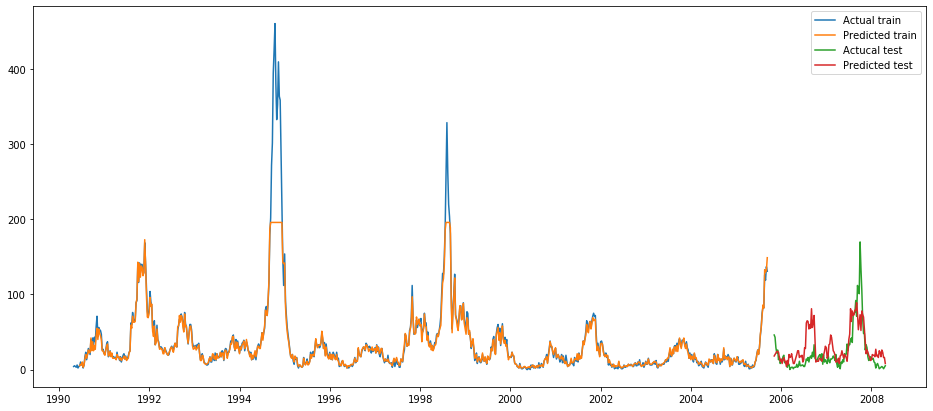

In [108]:

fig = plt.figure(figsize=(16,7))
plt.plot(sj_train_dates, y_train_sj, label = "Actual train")
plt.plot(sj_train_dates[7:], y_train_pred_sj, label = "Predicted train")
plt.plot(sj_test_dates[7:], y_test_sj[7:], label = "Actucal test")
plt.plot(sj_test_dates[7:], y_pred_sj, label = "Predicted test")
plt.legend()

In [0]:
model_iq = Sequential()
model_iq.add(LSTM(units=50, return_sequences=True, input_shape=(iq_train_x.shape[1], iq_train_x.shape[2])))
model_iq.add(LSTM(units=50))
model_iq.add(Dense(1))

In [0]:
model_iq.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
model_iq.fit(iq_train_x, iq_train_y, epochs=25, batch_size=1, verbose=1)

Epoch 1/25
393/393 [==============================] - 6s 16ms/step - loss: 107.1259
Epoch 2/25
393/393 [==============================] - 4s 10ms/step - loss: 76.2952
Epoch 3/25
393/393 [==============================] - 4s 10ms/step - loss: 70.5348
Epoch 4/25
393/393 [==============================] - 4s 10ms/step - loss: 62.8535
Epoch 5/25
393/393 [==============================] - 4s 10ms/step - loss: 58.8751
Epoch 6/25
393/393 [==============================] - 4s 9ms/step - loss: 59.3402
Epoch 7/25
393/393 [==============================] - 4s 9ms/step - loss: 54.7960
Epoch 8/25
393/393 [==============================] - 4s 10ms/step - loss: 53.3307
Epoch 9/25
393/393 [==============================] - 4s 9ms/step - loss: 51.1735
Epoch 10/25
393/393 [==============================] - 4s 9ms/step - loss: 49.4883
Epoch 11/25
393/393 [==============================] - 4s 10ms/step - loss: 49.1442
Epoch 12/25
393/393 [==============================] - 4s 10ms/step - loss: 47.1099
Epoc

In [0]:
iq_test_dates = X_test_iq.index
X_test_iq = X_test_iq.values
y_test_iq = y_test_iq.values

In [0]:
iq_test_x, iq_test_y = [], []
for i in range(7,len(X_test_iq)):
    iq_test_x.append(X_test_iq[i-7:i])
    iq_test_y.append(y_test_iq[i])
iq_test_x, iq_test_y = np.array(iq_test_x), np.array(iq_test_y)

In [0]:
iq_test_x.shape

(120, 7, 12)

In [0]:
y_pred_iq = model_iq.predict(iq_test_x)
y_pred_iq = [int(round(y,0)) for y in y_pred_iq[:,0]]

In [0]:
y_train_pred_iq = model_iq.predict(iq_train_x)
y_train_pred_iq = [int(round(y,0)) for y in y_train_pred_iq[:,0]]

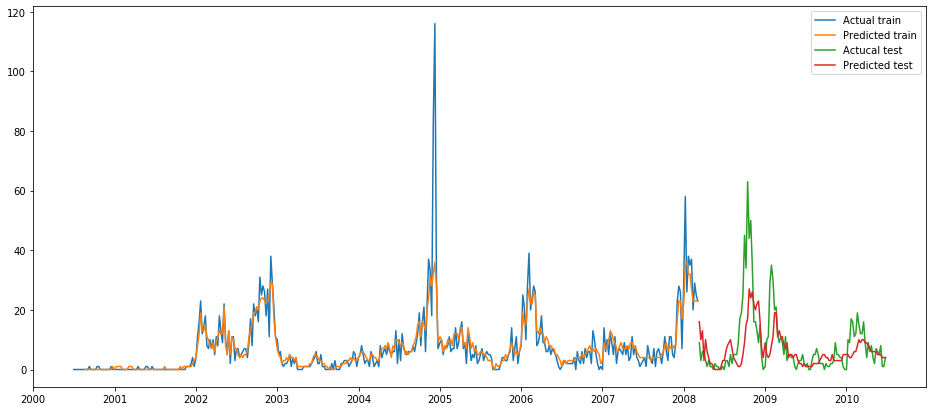

In [0]:
fig = plt.figure(figsize=(16,7))
plt.plot(iq_train_dates, y_train_iq, label = "Actual train")
plt.plot(iq_train_dates[7:], y_train_pred_iq, label = "Predicted train")
plt.plot(iq_test_dates[7:], y_test_iq[7:], label = "Actucal test")
plt.plot(iq_test_dates[7:], y_pred_iq, label = "Predicted test")
plt.legend()